## render GIF

In [ ]:
import imageio
import os

In [ ]:
image = []
for im in os.listdir('../results/'):
    if im[-3:] == 'png':
        image.append(im)
image.sort()

In [ ]:
images = []
for im in image:
    images.append(imageio.imread('../results/'+im))
    
imageio.mimsave('../results/score.gif', images, fps=1)

## simulated vs real tracks

In [1]:
import numpy as np
import pandas as pd
from scipy.interpolate import  splrep, splev
import scipy.stats as st

from utils.tools import *

In [2]:
import torch
from torch import nn

class CNNGenerator(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(    
            nn.ConvTranspose1d(256, 128, kernel_size = 25, stride = 2, padding = 0, bias = False),
            nn.BatchNorm1d(128),
            nn.ReLU(True),

            nn.ConvTranspose1d(128, 32, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(32),
            nn.ReLU(True),

            nn.ConvTranspose1d(32, 8, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(8),
            nn.ReLU(True),

            nn.ConvTranspose1d(8, 2, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.Tanh()
         )

    def forward(self, z):    
        out = self.cnn(z)

        return out
    


class CNNDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
                
        self.cnn = nn.Sequential(
            nn.Conv1d(2, 8, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(8),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv1d(8, 32, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv1d(32, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv1d(128, 1, kernel_size=25, stride=2, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.cnn(x)
        return out.squeeze(1)


class Smoother(nn.Module):
    def __init__(self):
        super().__init__()
        self.smooth = nn.Conv1d(2,2, kernel_size = 5, stride = 1, padding = 2, bias = False)

    def forward(self, z):    
        out = self.smooth(z)
        return out

sm = Smoother()

for param in sm.smooth.parameters():
    param.requires_grad = False

w = torch.zeros((2,2,5))
w[0,0,:] = 1/5
w[1,1,:] = 1/5

sm.smooth.weight.data = w

In [17]:
generator = torch.load('../../results/basicGAN_cnn_G_SV.pt')

nb = 100

z = torch.randn((nb, 256, 1))
generated = generator(z)
traj = sm(generated).detach().numpy()

In [18]:
colony = (-77.264, -11.773)
scale = 30000

data_fake = format_simulation(traj, colony, scale)
data_fake = data_fake[data_fake.dist_colony > 1000]

In [103]:
# simGAN = data_fake
simGAN = pd.read_table("/home/amdroy/MEGA/SCRIPT/BirdGAN/results/sim_GAN_SV_2008.csv", sep =',')

In [104]:
simHMM_raw = pd.read_table("/home/amdroy/MEGA/SCRIPT/BirdGAN/results/sim_HMM_SV_2008.csv", sep =',')
simHMM_raw['lon'] = simHMM_raw.x * 180/np.pi/6371 + colony[0]
simHMM_raw['lat'] = simHMM_raw.y * 180/np.pi/6371 + colony[1]
simHMM_raw['trip'] = simHMM_raw.ID


simHMM = pd.DataFrame()

for t in simHMM_raw.trip.unique():
    traj = simHMM_raw[simHMM_raw.trip == t].copy()
    
    if sum((traj['colony.dist'] < 1) & (traj.states == 3)) > 1:
    
        i =  min(np.where((traj['colony.dist'] < 1) & (traj.states == 3))[0])
        traj = traj.iloc[:i+1]

        simHMM = simHMM.append(traj, ignore_index=True)

simHMM = format_data(simHMM, colony, scale)
# simHMM = simHMM[simHMM.dist_colony > 1000]
simHMM

,Unnamed: 0,ID,step,angle,x,y,time,colony.dist,colony.angle,states,lon,lat,trip,x_std,y_std,dist_colony,step_distance,step_direction
0,1,1,0.817573,NaN,0.000000,0.000000,0.016667,0.000000,0.000000,1,-77.264000,-11.773000,1,0.000000,0.000000,0.000000,NaN,NaN
1,2,1,1.014133,0.049528,-509.454409,640.541708,0.033333,0.817573,3.141593,1,-77.268577,-11.767246,1,-0.016982,0.021351,811.811447,811.811447,NaN
2,3,1,0.891407,2.044436,-1179.952384,1402.821153,0.050000,1.831150,3.119486,2,-77.274600,-11.760397,1,-0.039332,0.046761,1817.221720,1005.957588,-2.827328
3,4,1,0.185699,-0.811437,-1507.400372,572.723506,0.066667,1.610834,1.583430,2,-77.277542,-11.767855,1,-0.050247,0.019091,1582.944859,889.846751,-118.151506
4,5,1,0.655853,0.313590,-1679.782907,503.145028,0.083333,1.751669,2.466937,1,-77.279091,-11.768480,1,-0.055993,0.016772,1719.710248,182.539948,46.478322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10594,73102,100,1.045734,0.138953,2507.117025,-3941.587830,1.750000,4.666449,0.261978,3,-77.241477,-11.808410,100,0.083571,-0.131386,4643.199495,1239.055803,23.288183
10595,7499,100,1.231988,0.209021,2057.921300,-2996.023630,1.766667,3.630888,0.158375,3,-77.245512,-11.799915,100,0.068597,-0.099867,3610.331635,1042.796507,-7.837856
10596,7598,100,1.142631,0.014710,1309.084571,-2016.102197,1.783333,2.401289,-0.076622,3,-77.252240,-11.791112,100,0.043636,-0.067203,2388.916174,1223.752412,-11.859484
10597,7698,100,0.893283,0.080138,601.268302,-1117.570599,1.800000,1.267712,-0.173631,3,-77.258598,-11.783040,100,0.020042,-0.037252,1263.101210,1134.661546,-0.839019


In [105]:
# looping trajectories
len(simHMM.ID.unique())/100

0.93

In [106]:
data = pd.read_table('/home/amdroy/MEGA/SCRIPT/BirdGAN/data/trips_SV_2008_formatted.csv', sep = ',')
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d %H:%M:%S')

colony = (-77.264, -11.773)

data = format_data(data, colony, scale)
data = data[data.dist_colony > 1000]

### maps

In [107]:
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt
import matplotlib.markers as mk
from netCDF4 import Dataset

In [108]:
dicolour = { 'blue':   '#1f77b4',  # muted blue
             'orange': '#ff7f0e',  # safety orange
             'green':  '#2ca02c',  # cooked asparagus green
             'red':    '#d62728',  # brick red
             'purple': '#9467bd',  # muted purple
             'brown':  '#8c564b',  # chestnut brown
             'pink':   '#e377c2',  # raspberry     yogurt pink
             'gray':   '#7f7f7f',  # middle gray
             'yellow': '#bcbd22'   # curry yellow-green
           }

In [109]:
A1 = (-77.8, -77, -12.3, -11.4)

Text(0.5, 1.0, 'HMM')

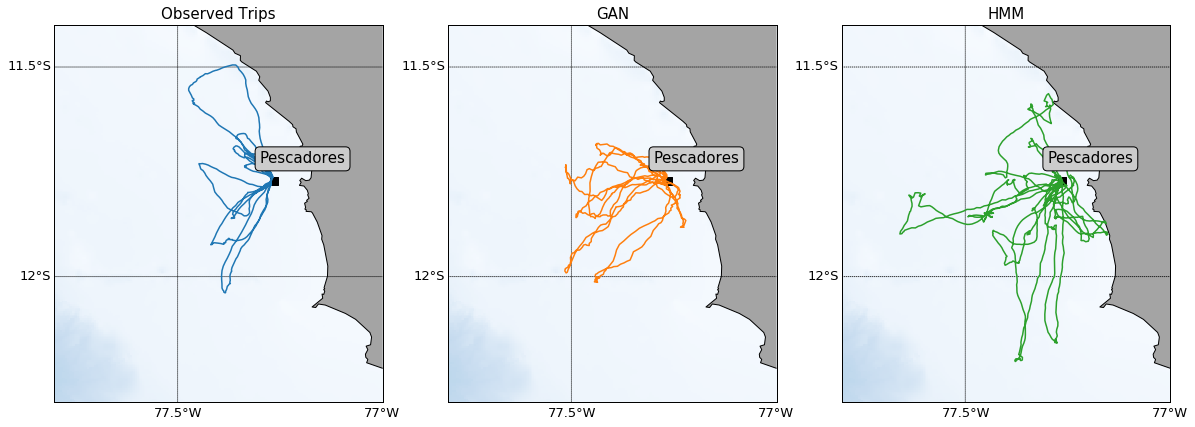

In [110]:
plt.figure(figsize=(20,20))

long_min, long_max = A1[0], A1[1]
lat_min, lat_max = A1[2], A1[3]

lon = data.lon[data.trip.isin(data.trip.unique()[:10])]
lat = data.lat[data.trip.isin(data.trip.unique()[:10])]
nb = len(data.trip.unique())


plt.subplot(1,3,1)
# create map using BASEMAP
m = Basemap(llcrnrlon=long_min,
            llcrnrlat=lat_min,
            urcrnrlon=long_max,
            urcrnrlat=lat_max,
            lat_0=(lat_max - lat_min)/2,
            lon_0=(long_max-long_min)/2,
            projection='merc',
            resolution = 'h',
            area_thresh=10000.,
            )

# coast line and continents
m.drawcoastlines()
m.drawmapboundary(fill_color='#CEECF5')
m.fillcontinents(color = '#A4A4A4',lake_color='#CEECF5')

# meridians and parallels
parallels = np.arange(-15,-5,0.5)
meridians = np.arange(-80,-75,0.5)
labels = [True,False,False,True]
m.drawparallels(parallels, labels = labels, fontsize = 13)
m.drawmeridians(meridians, labels = labels, fontsize = 13)

# bathymetry
gebco = Dataset('/home/amdroy/MEGA/DATA/SATELLITE/GEBCO/gebco_2019_pescadores.nc')
lat_gebco = gebco.variables['lat'][:]
lon_gebco = gebco.variables['lon'][:]
lon_gebco, lat_gebco = np.meshgrid(lon_gebco, lat_gebco)
bathy = gebco.variables['elevation'][:]
m.pcolormesh(lon_gebco, lat_gebco, bathy, latlon = True, cmap='Blues_r', vmin = -6000, vmax=100)    

# trips
x, y = m(lon.values, lat.values)
m.plot(x, y, alpha= 1, color = dicolour['blue'])
# m.scatter(x, y, marker = 'o', s = 30*(weight>0.5), alpha= 0.5, edgecolors = None, color = dicolour['red'])

## colony
x, y = m(-77.264, -11.773)
m.scatter(x, y, marker = 's', s = 50, color = 'black', alpha= 1)
xt, yt = m(-77.3, -11.73)
plt.annotate('Pescadores', xy = (x, y), fontsize = 15, xytext = (xt, yt), 
             bbox = dict(boxstyle="round", fc="0.8"))

# map scale
# m.drawmapscale(-77.85, -12.35, -77.264, -11.773, 50, barstyle='fancy', fontsize = 13)
# plt.show()

plt.title('Observed Trips', fontsize = 15)


lon = simGAN.lon[simGAN.trip.isin(simGAN.trip.unique()[:10])]
lat = simGAN.lat[simGAN.trip.isin(simGAN.trip.unique()[:10])]

plt.subplot(1,3,2)
# create map using BASEMAP
m = Basemap(llcrnrlon=long_min,
            llcrnrlat=lat_min,
            urcrnrlon=long_max,
            urcrnrlat=lat_max,
            lat_0=(lat_max - lat_min)/2,
            lon_0=(long_max-long_min)/2,
            projection='merc',
            resolution = 'h',
            area_thresh=10000.,
            )

# coast line and continents
m.drawcoastlines()
m.drawmapboundary(fill_color='#CEECF5')
m.fillcontinents(color = '#A4A4A4',lake_color='#CEECF5')

# meridians and parallels
parallels = np.arange(-15,-5,0.5)
meridians = np.arange(-80,-75,0.5)
labels = [True,False,False,True]
m.drawparallels(parallels, labels = labels, fontsize = 13)
m.drawmeridians(meridians, labels = labels, fontsize = 13)

# bathymetry
gebco = Dataset('/home/amdroy/MEGA/DATA/SATELLITE/GEBCO/gebco_2019_pescadores.nc')
lat_gebco = gebco.variables['lat'][:]
lon_gebco = gebco.variables['lon'][:]
lon_gebco, lat_gebco = np.meshgrid(lon_gebco, lat_gebco)
bathy = gebco.variables['elevation'][:]
m.pcolormesh(lon_gebco, lat_gebco, bathy, latlon = True, cmap='Blues_r', vmin = -6000, vmax=100)    

# trips
x, y = m(lon.values, lat.values)
m.plot(x, y, alpha= 1, color = dicolour['orange'])
# m.scatter(x, y, marker = 'o', s = 30*(weight>0.5), alpha= 0.5, edgecolors = None, color = dicolour['red'])

## colony
x, y = m(-77.264, -11.773)
m.scatter(x, y, marker = 's', s = 50, color = 'black', alpha= 1)
xt, yt = m(-77.3, -11.73)
plt.annotate('Pescadores', xy = (x, y), fontsize = 15, xytext = (xt, yt), 
             bbox = dict(boxstyle="round", fc="0.8"))

# map scale
# m.drawmapscale(-77.85, -12.35, -77.264, -11.773, 50, barstyle='fancy', fontsize = 13)
# plt.show()

plt.title('GAN', fontsize = 15)


lon = simHMM.lon[simHMM.trip.isin(simHMM.trip.unique()[:10])]
lat = simHMM.lat[simHMM.trip.isin(simHMM.trip.unique()[:10])]

plt.subplot(1,3,3)
# create map using BASEMAP
m = Basemap(llcrnrlon=long_min,
            llcrnrlat=lat_min,
            urcrnrlon=long_max,
            urcrnrlat=lat_max,
            lat_0=(lat_max - lat_min)/2,
            lon_0=(long_max-long_min)/2,
            projection='merc',
            resolution = 'h',
            area_thresh=10000.,
            )

# coast line and continents
m.drawcoastlines()
m.drawmapboundary(fill_color='#CEECF5')
m.fillcontinents(color = '#A4A4A4',lake_color='#CEECF5')

# meridians and parallels
parallels = np.arange(-15,-5,0.5)
meridians = np.arange(-80,-75,0.5)
labels = [True,False,False,True]
m.drawparallels(parallels, labels = labels, fontsize = 13)
m.drawmeridians(meridians, labels = labels, fontsize = 13)

# bathymetry
gebco = Dataset('/home/amdroy/MEGA/DATA/SATELLITE/GEBCO/gebco_2019_pescadores.nc')
lat_gebco = gebco.variables['lat'][:]
lon_gebco = gebco.variables['lon'][:]
lon_gebco, lat_gebco = np.meshgrid(lon_gebco, lat_gebco)
bathy = gebco.variables['elevation'][:]
m.pcolormesh(lon_gebco, lat_gebco, bathy, latlon = True, cmap='Blues_r', vmin = -6000, vmax=100)    

# trips
x, y = m(lon.values, lat.values)
m.plot(x, y, alpha= 1, color = dicolour['green'])
# m.scatter(x, y, marker = 'o', s = 30*(weight>0.5), alpha= 0.5, edgecolors = None, color = dicolour['red'])

## colony
x, y = m(-77.264, -11.773)
m.scatter(x, y, marker = 's', s = 50, color = 'black', alpha= 1)
xt, yt = m(-77.3, -11.73)
plt.annotate('Pescadores', xy = (x, y), fontsize = 15, xytext = (xt, yt), 
             bbox = dict(boxstyle="round", fc="0.8"))

# map scale
# m.drawmapscale(-77.85, -12.35, -77.264, -11.773, 50, barstyle='fancy', fontsize = 13)
# plt.show()

plt.title('HMM', fontsize = 15)

Text(0.5, 1.0, 'HMM')

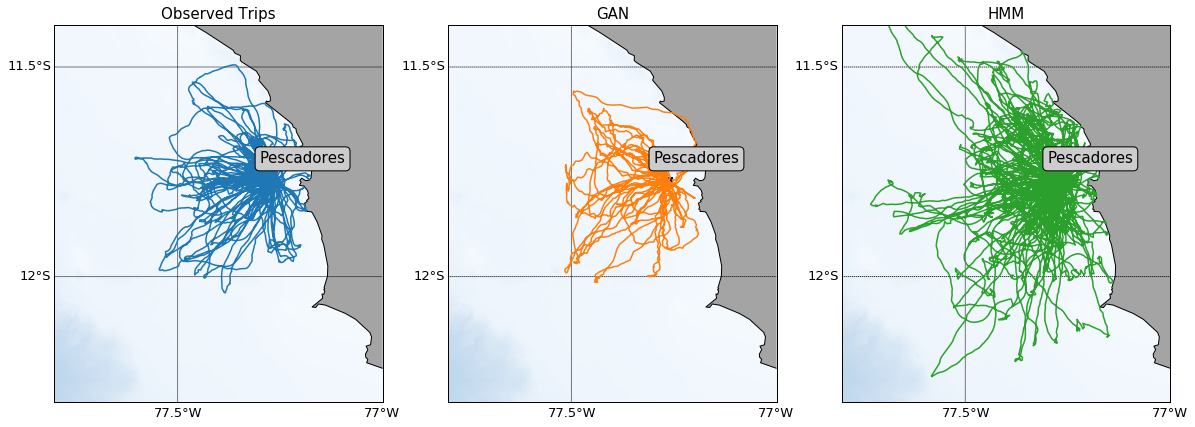

In [111]:
plt.figure(figsize=(20,20))

long_min, long_max = A1[0], A1[1]
lat_min, lat_max = A1[2], A1[3]

lon = data.lon
lat = data.lat
nb = len(data.trip.unique())


plt.subplot(1,3,1)
# create map using BASEMAP
m = Basemap(llcrnrlon=long_min,
            llcrnrlat=lat_min,
            urcrnrlon=long_max,
            urcrnrlat=lat_max,
            lat_0=(lat_max - lat_min)/2,
            lon_0=(long_max-long_min)/2,
            projection='merc',
            resolution = 'h',
            area_thresh=10000.,
            )

# coast line and continents
m.drawcoastlines()
m.drawmapboundary(fill_color='#CEECF5')
m.fillcontinents(color = '#A4A4A4',lake_color='#CEECF5')

# meridians and parallels
parallels = np.arange(-15,-5,0.5)
meridians = np.arange(-80,-75,0.5)
labels = [True,False,False,True]
m.drawparallels(parallels, labels = labels, fontsize = 13)
m.drawmeridians(meridians, labels = labels, fontsize = 13)

# bathymetry
gebco = Dataset('/home/amdroy/MEGA/DATA/SATELLITE/GEBCO/gebco_2019_pescadores.nc')
lat_gebco = gebco.variables['lat'][:]
lon_gebco = gebco.variables['lon'][:]
lon_gebco, lat_gebco = np.meshgrid(lon_gebco, lat_gebco)
bathy = gebco.variables['elevation'][:]
m.pcolormesh(lon_gebco, lat_gebco, bathy, latlon = True, cmap='Blues_r', vmin = -6000, vmax=100)    

# trips
x, y = m(lon.values, lat.values)
m.plot(x, y, alpha= 1, color = dicolour['blue'])
# m.scatter(x, y, marker = 'o', s = 30*(weight>0.5), alpha= 0.5, edgecolors = None, color = dicolour['red'])

## colony
x, y = m(-77.264, -11.773)
m.scatter(x, y, marker = 's', s = 50, color = 'black', alpha= 1)
xt, yt = m(-77.3, -11.73)
plt.annotate('Pescadores', xy = (x, y), fontsize = 15, xytext = (xt, yt), 
             bbox = dict(boxstyle="round", fc="0.8"))

# map scale
# m.drawmapscale(-77.85, -12.35, -77.264, -11.773, 50, barstyle='fancy', fontsize = 13)
# plt.show()

plt.title('Observed Trips', fontsize = 15)


lon = simGAN.lon
lat = simGAN.lat

plt.subplot(1,3,2)
# create map using BASEMAP
m = Basemap(llcrnrlon=long_min,
            llcrnrlat=lat_min,
            urcrnrlon=long_max,
            urcrnrlat=lat_max,
            lat_0=(lat_max - lat_min)/2,
            lon_0=(long_max-long_min)/2,
            projection='merc',
            resolution = 'h',
            area_thresh=10000.,
            )

# coast line and continents
m.drawcoastlines()
m.drawmapboundary(fill_color='#CEECF5')
m.fillcontinents(color = '#A4A4A4',lake_color='#CEECF5')

# meridians and parallels
parallels = np.arange(-15,-5,0.5)
meridians = np.arange(-80,-75,0.5)
labels = [True,False,False,True]
m.drawparallels(parallels, labels = labels, fontsize = 13)
m.drawmeridians(meridians, labels = labels, fontsize = 13)

# bathymetry
gebco = Dataset('/home/amdroy/MEGA/DATA/SATELLITE/GEBCO/gebco_2019_pescadores.nc')
lat_gebco = gebco.variables['lat'][:]
lon_gebco = gebco.variables['lon'][:]
lon_gebco, lat_gebco = np.meshgrid(lon_gebco, lat_gebco)
bathy = gebco.variables['elevation'][:]
m.pcolormesh(lon_gebco, lat_gebco, bathy, latlon = True, cmap='Blues_r', vmin = -6000, vmax=100)    

# trips
x, y = m(lon.values, lat.values)
m.plot(x, y, alpha= 1, color = dicolour['orange'])
# m.scatter(x, y, marker = 'o', s = 30*(weight>0.5), alpha= 0.5, edgecolors = None, color = dicolour['red'])

## colony
x, y = m(-77.264, -11.773)
m.scatter(x, y, marker = 's', s = 50, color = 'black', alpha= 1)
xt, yt = m(-77.3, -11.73)
plt.annotate('Pescadores', xy = (x, y), fontsize = 15, xytext = (xt, yt), 
             bbox = dict(boxstyle="round", fc="0.8"))

# map scale
# m.drawmapscale(-77.85, -12.35, -77.264, -11.773, 50, barstyle='fancy', fontsize = 13)
# plt.show()

plt.title('GAN', fontsize = 15)


lon = simHMM.lon
lat = simHMM.lat

plt.subplot(1,3,3)
# create map using BASEMAP
m = Basemap(llcrnrlon=long_min,
            llcrnrlat=lat_min,
            urcrnrlon=long_max,
            urcrnrlat=lat_max,
            lat_0=(lat_max - lat_min)/2,
            lon_0=(long_max-long_min)/2,
            projection='merc',
            resolution = 'h',
            area_thresh=10000.,
            )

# coast line and continents
m.drawcoastlines()
m.drawmapboundary(fill_color='#CEECF5')
m.fillcontinents(color = '#A4A4A4',lake_color='#CEECF5')

# meridians and parallels
parallels = np.arange(-15,-5,0.5)
meridians = np.arange(-80,-75,0.5)
labels = [True,False,False,True]
m.drawparallels(parallels, labels = labels, fontsize = 13)
m.drawmeridians(meridians, labels = labels, fontsize = 13)

# bathymetry
gebco = Dataset('/home/amdroy/MEGA/DATA/SATELLITE/GEBCO/gebco_2019_pescadores.nc')
lat_gebco = gebco.variables['lat'][:]
lon_gebco = gebco.variables['lon'][:]
lon_gebco, lat_gebco = np.meshgrid(lon_gebco, lat_gebco)
bathy = gebco.variables['elevation'][:]
m.pcolormesh(lon_gebco, lat_gebco, bathy, latlon = True, cmap='Blues_r', vmin = -6000, vmax=100)    

# trips
x, y = m(lon.values, lat.values)
m.plot(x, y, alpha= 1, color = dicolour['green'])
# m.scatter(x, y, marker = 'o', s = 30*(weight>0.5), alpha= 0.5, edgecolors = None, color = dicolour['red'])

## colony
x, y = m(-77.264, -11.773)
m.scatter(x, y, marker = 's', s = 50, color = 'black', alpha= 1)
xt, yt = m(-77.3, -11.73)
plt.annotate('Pescadores', xy = (x, y), fontsize = 15, xytext = (xt, yt), 
             bbox = dict(boxstyle="round", fc="0.8"))

# map scale
# m.drawmapscale(-77.85, -12.35, -77.264, -11.773, 50, barstyle='fancy', fontsize = 13)
# plt.show()

plt.title('HMM', fontsize = 15)

In [112]:
def get_mean_dist(data):
    var = []
    for tt in data.trip.unique():
        traj = data[data.trip == tt].copy()
        
        lon = np.array([traj.lon.values for i in range(len(traj))])
        lat = np.array([traj.lat.values for i in range(len(traj))])
        
        d = dist_ortho(lon, lat, lon.T, lat.T)
        
        var.append(np.mean(np.sum(d < 500, axis = 1)))
        
    return np.array(var)

Text(0.5, 1.0, 'Step Direction (degree)')

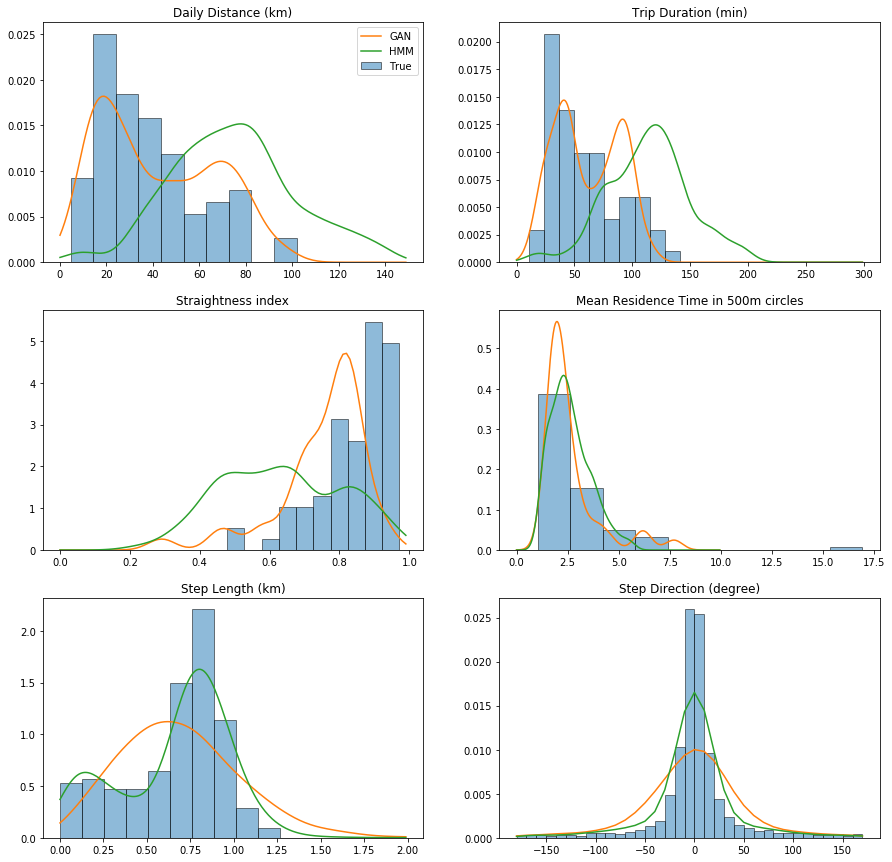

In [113]:
plt.figure(figsize = (15,15))

plt.subplot(3,2,1)
## DAILY DISTANCE
y = get_trip_dist(data)

y_GAN = get_trip_dist(simGAN)
y_HMM = get_trip_dist(simHMM)
dy_GAN = kde1d(y_GAN/1e3, bw = 0.3)
dy_HMM = kde1d(y_HMM/1e3, bw = 0.3)

bins = np.arange(0, 150, 10)
# plt.hist(y/1e3, alpha = 0.5, edgecolor='k', bins = bins, density = True, color = dicolour['blue'], label = 'True')
# plt.hist(y_false/1e3, alpha = 0.5, edgecolor='k', bins = bins, density = True, color = dicolour['orange'], label = 'Simulation')
x = np.arange(0,150, 1)
plt.hist(y/1e3, color = dicolour['blue'], label = 'True', alpha = 0.5, edgecolor='k', density = True)
plt.plot(x, dy_GAN(x), color = dicolour['orange'], label = 'GAN')
plt.plot(x, dy_HMM(x), color = dicolour['green'], label = 'HMM')
plt.legend()
plt.title('Daily Distance (km)')

plt.subplot(3,2,2)
## FORAGING DURATION
y = get_trip_duration(data)
y_GAN = get_trip_duration(simGAN)
y_HMM = get_trip_duration(simHMM)
dy_GAN = kde1d(y_GAN, bw = 0.3)
dy_HMM = kde1d(y_HMM, bw = 0.3)

bins = np.arange(0, 300, 15)
# plt.hist(y, alpha = 0.5, edgecolor='k', bins = bins, density = True, color = dicolour['blue'], label = 'True')
# plt.hist(y_false, alpha = 0.5, edgecolor='k', bins = bins, density = True, color = dicolour['orange'], label = 'Simulation')

x = np.arange(0,300, 1)
plt.hist(y, color = dicolour['blue'], label = 'True', alpha = 0.5, edgecolor='k', density = True)
plt.plot(x, dy_GAN(x), color = dicolour['orange'], label = 'GAN')
plt.plot(x, dy_HMM(x), color = dicolour['green'], label = 'HMM')
plt.title('Trip Duration (min)')

plt.subplot(3,2,3)
# STRAIGHTNESS INDEX
y = get_trip_sinuosity(data)
y_GAN = get_trip_sinuosity(simGAN)
y_HMM = get_trip_sinuosity(simHMM)
dy_GAN = kde1d(y_GAN, bw = 0.3)
dy_HMM = kde1d(y_HMM, bw = 0.3)

x = np.arange(0,1, 0.01)
plt.hist(y, color = dicolour['blue'], label = 'True', alpha = 0.5, edgecolor='k', density = True)
plt.plot(x, dy_GAN(x), color = dicolour['orange'], label = 'GAN')
plt.plot(x, dy_HMM(x), color = dicolour['green'], label = 'HMM')
plt.title('Straightness index')


plt.subplot(3,2,4)
# MEAN residence time in 500m radius 
y = get_mean_dist(data)
y_GAN = get_mean_dist(simGAN)
y_HMM = get_mean_dist(simHMM)
dy_GAN = kde1d(y_GAN, bw = 0.3)
dy_HMM = kde1d(y_HMM, bw = 0.3)

x = np.arange(0,10, 0.05)
plt.hist(y, color = dicolour['blue'], label = 'True', alpha = 0.5, edgecolor='k', density = True)
plt.plot(x, dy_GAN(x), color = dicolour['orange'], label = 'GAN')
plt.plot(x, dy_HMM(x), color = dicolour['green'], label = 'HMM')
plt.title('Mean Residence Time in 500m circles')


plt.subplot(3,2,5)
# STEP LENGTH
y_GAN = simGAN.step_distance/1e3
y_HMM = simHMM.step_distance/1e3
dy_GAN = kde1d(y_GAN.dropna(), bw = 0.3)
dy_HMM = kde1d(y_HMM.dropna(), bw = 0.3)

x = np.arange(0,2, 0.01)
plt.hist(data.step_distance.dropna()/1e3, color = dicolour['blue'], label = 'True', alpha = 0.5, edgecolor='k', density = True)
plt.plot(x, dy_GAN(x), color = dicolour['orange'], label = 'GAN')
plt.plot(x, dy_HMM(x), color = dicolour['green'], label = 'HMM')
plt.title('Step Length (km)')

plt.subplot(3,2,6)
# STEP DIRECTION
y_GAN = simGAN.step_direction
y_HMM = simHMM.step_direction
dy_GAN = kde1d(y_GAN.dropna(), bw = 0.3)
dy_HMM = kde1d(y_HMM.dropna(), bw = 0.3)

x = np.arange(-180,180, 10)
plt.hist(data.step_direction, bins = x, color = dicolour['blue'], label = 'True', alpha = 0.5, edgecolor='k', density = True)
plt.plot(x, dy_GAN(x), color = dicolour['orange'], label = 'GAN')
plt.plot(x, dy_HMM(x), color = dicolour['green'], label = 'HMM')
plt.title('Step Direction (degree)')
# score_foraging_times = np.sum((dy_false/np.sum(dy_false) - dy/np.sum(dy))**2) / np.sum( (dy/np.sum(dy))**2)

#     return  [score_daily_dist, score_foraging_duration]

In [114]:
simGAN_pad = padding_data(simGAN, 200)
simHMM_pad = padding_data(simHMM, 200)

In [115]:
import scipy.signal

In [128]:
def get_periodogram(data):
    traj = padding_data(data, 200)
    
    periodogram_lon = []
    periodogram_lat = []

    for j in range(traj.shape[0]):
        lon = traj[j, 0, :]
        lat = traj[j, 1, :]
        x, lon = scipy.signal.periodogram(lon, scaling = 'spectrum', detrend = False)
        x, lat = scipy.signal.periodogram(lat, scaling = 'spectrum', detrend = False)
        
        periodogram_lon.append(lon)
        periodogram_lat.append(lat)
        
    return (x, np.array(periodogram_lon), np.array(periodogram_lat))
    

In [129]:
x, lon, lat = get_periodogram(data)
x, lon_GAN, lat_GAN = get_periodogram(simGAN)
x, lon_HMM, lat_HMM = get_periodogram(simHMM)

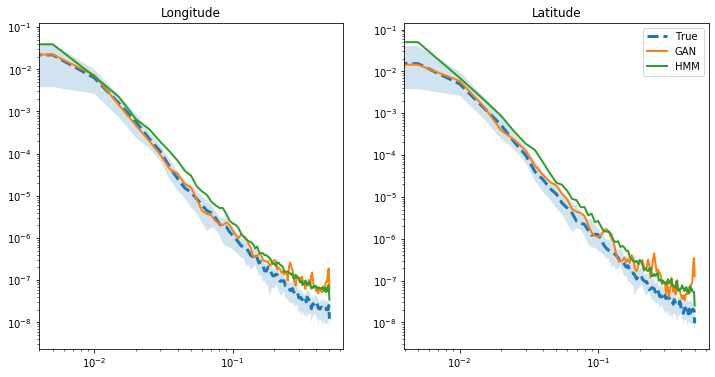

In [137]:
plt.figure(figsize = (12,6))

plt.subplot(1,2,1)
plt.loglog(x, np.mean(lon, axis=0), linewidth = 3, linestyle = '--')
plt.fill_between(x, np.mean(lon, axis=0) - 0.5 * np.std(lon, axis=0) ,  
                 np.mean(lon, axis=0) + 0.5 * np.std(lon, axis=0),
                alpha = 0.2)


plt.loglog(x, np.mean(lon_GAN, axis=0), linewidth = 2)
# plt.fill_between(x, np.mean(lon_GAN, axis=0) - 0.5 * np.std(lon_GAN, axis=0) ,  
#                  np.mean(lon_GAN, axis=0) + 0.5 * np.std(lon_GAN, axis=0),
#                  alpha = 0.2)

plt.loglog(x, np.mean(lon_HMM, axis=0), linewidth = 2)
# plt.fill_between(x, np.mean(lon_HMM, axis=0) - 0.5 * np.std(lon_HMM, axis=0) ,  
#                  np.mean(lon_HMM, axis=0) + 0.5 * np.std(lon_HMM, axis=0),
#                  alpha = 0.2)

# plt.xlim([0.005, 0.5])
# plt.ylim([1e-6, 1e1])
plt.title('Longitude')

plt.subplot(1,2,2)
plt.loglog(x, np.mean(lat, axis=0), linewidth = 3, linestyle = '--', label = 'True')
plt.fill_between(x, np.mean(lon, axis=0) - 0.5 * np.std(lon, axis=0) ,  
                 np.mean(lon, axis=0) + 0.5 * np.std(lon, axis=0),
                alpha = 0.2)

plt.loglog(x, np.mean(lat_GAN, axis=0), linewidth = 2, label = 'GAN')
# plt.fill_between(x, np.mean(lat_GAN, axis=0) - 0.5 * np.std(lat_GAN, axis=0) ,  
#                  np.mean(lat_GAN, axis=0) + 0.5 * np.std(lat_GAN, axis=0),
#                  alpha = 0.2)

plt.loglog(x, np.mean(lat_HMM, axis=0), linewidth = 2, label = 'HMM')
# plt.fill_between(x, np.mean(lat_HMM, axis=0) - 0.5 * np.std(lat_HMM, axis=0) ,  
#                  np.mean(lat_HMM, axis=0) + 0.5 * np.std(lat_HMM, axis=0),
#                  alpha = 0.2)

# plt.xlim([0, 0.5])
# plt.ylim([1e-6, 1e1])
plt.legend()
plt.title('Latitude')

plt.show()

In [48]:
np.sum(lon_HMM*np.log(lon_HMM/lon))

18.641838120096793

In [49]:
np.sum(lon_GAN*np.log(lon_GAN/lon))

0.1750700603881419

In [50]:
np.sum(lat_HMM*np.log(lat_HMM/lat))

35.423784084250755

In [52]:
np.sum(lat_GAN*np.log(lat_GAN/lat))

-0.15450188772444007

### Explo stat differences

(array([48., 19.,  6.,  4.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 1.04545455,  2.63382944,  4.22220434,  5.81057924,  7.39895414,
         8.98732904, 10.57570394, 12.16407884, 13.75245374, 15.34082864,
        16.92920354]),
 <a list of 10 Patch objects>)

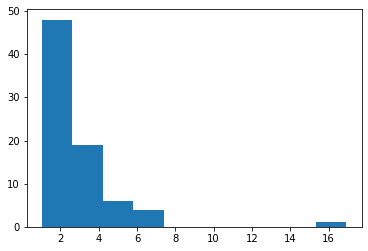

In [297]:
plt.hist(get_mean_dist(data))

(array([17., 12., 21., 14.,  9.,  9.,  5.,  2.,  2.,  2.]),
 array([1.21686747, 1.65271497, 2.08856247, 2.52440997, 2.96025747,
        3.39610497, 3.83195247, 4.26779997, 4.70364747, 5.13949497,
        5.57534247]),
 <a list of 10 Patch objects>)

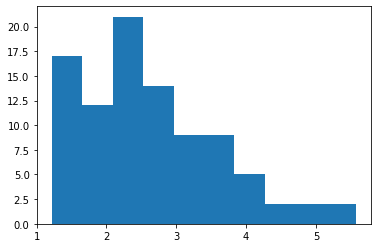

In [298]:
plt.hist(get_mean_dist(simHMM))

(array([18., 10.,  4.,  2.,  1.,  1.,  0.,  2.,  0.,  1.]),
 array([1.4       , 2.03058824, 2.66117647, 3.29176471, 3.92235294,
        4.55294118, 5.18352941, 5.81411765, 6.44470588, 7.07529412,
        7.70588235]),
 <a list of 10 Patch objects>)

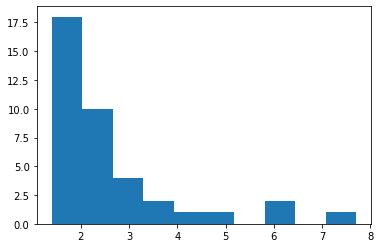

In [299]:
plt.hist(get_mean_dist(simGAN))